In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import numpy as np

class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(784, 100, bias=False)
        self.linear2 = nn.Linear(100, 200, bias=False)
        self.linear3 = nn.Linear(200, 10, bias=False)

    def forward(self, x, scale_list):
        
        self.linear1.weight.data = torch.clamp(self.linear1.weight.data, -0.5, 0.5)
        out = self.linear1(x)
        out = out*scale_list[0]
        out = torch.tanh(out)

        self.linear2.weight.data = torch.clamp(self.linear2.weight.data, -0.5, 0.5)
        out = self.linear2(out)
        out = out*scale_list[1]
        out = torch.tanh(out)

        self.linear3.weight.data = torch.clamp(self.linear3.weight.data, -1, 1)
        out = self.linear3(out)
        out = out*scale_list[2]
        out = torch.tanh(out)

        return out

In [2]:
# Set device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# Create model
model = FCNN().to(device)

# Set loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load MNIST dataset, split train and test
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = dsets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = dsets.MNIST(root='../data', train=False, transform=transform)

# train loader, test loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# check the min and max in dataloader
for i, (images, labels) in enumerate(train_loader):
    print(torch.min(images), torch.max(images))
    break

tensor(0.) tensor(1.)


In [ ]:
# Train the model
acc_max = 0
loss_min = 999
for epoch in range(30):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 784).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images, [1,1,1])
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    print('TRAIN: Epoch: {}, Loss: {:.4f}'.format(epoch + 1, loss.item()))

    # test the model
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.view(-1, 784).to(device)
            labels = labels.to(device)
            outputs = model(images, [1,1,1])
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # save best model, both accuracy and loss
        if (acc_max < 100 * correct / total) and (loss_min > loss.item()):
            acc_max = 100 * correct / total
            loss_min = loss.item()
            torch.save(model.state_dict(), '../saveddict/FCNN_MNIST.pt')
            print('saved at Epoch: {}, Accuracy: {:.2f}%, loss: {}'
                  .format(epoch + 1, 100 * correct / total, loss.item()))
            #Accuracy: 97.53%, loss: 0.7966966032981873

[[-1.          0.9999992  -0.99999684 -0.9999965  -0.99999994 -0.99999994
  -0.9999969  -0.99999994 -0.99961627 -0.9999997 ]]


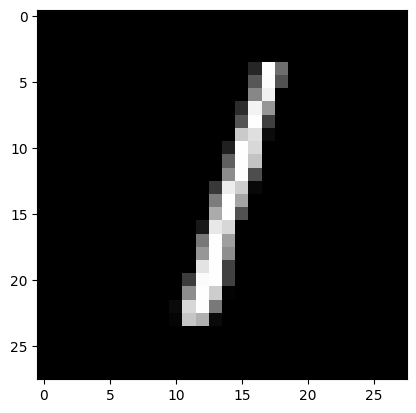

In [4]:
model2 = FCNN()
model2.load_state_dict(torch.load('../saveddict/FCNN_MNIST.pt'))

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

for i, (images, labels) in enumerate(test_loader):
    if i == 0:
        images = images.view(-1, 784)
        outputs = model2(images, [1,1,1])
        print(outputs.detach().numpy())
        # plot images
        plt.imshow(images[0].reshape(28, 28), cmap='gray')
        plt.show()
        break


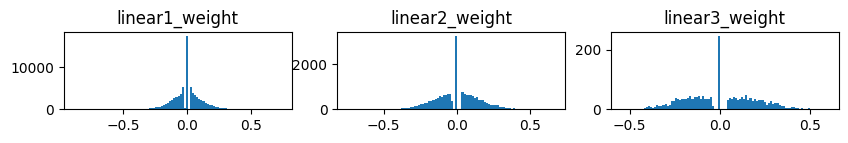

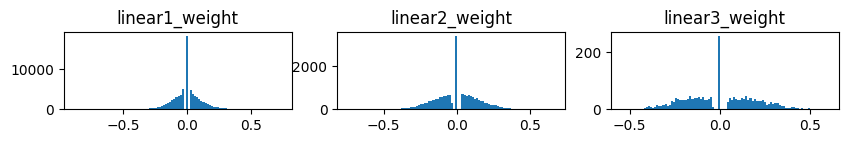

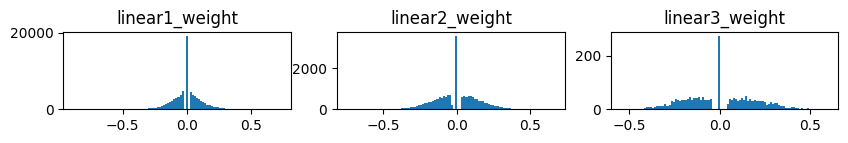

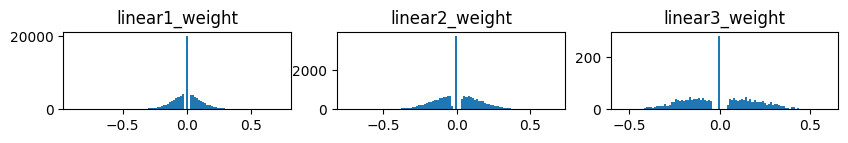

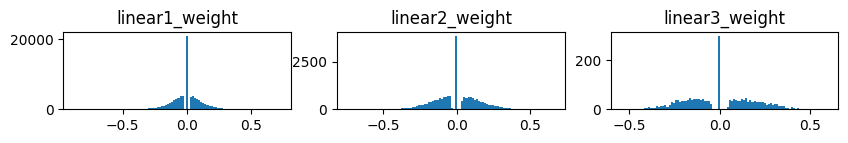

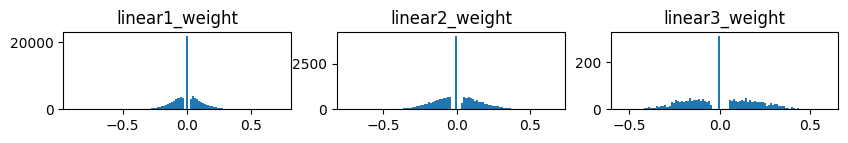

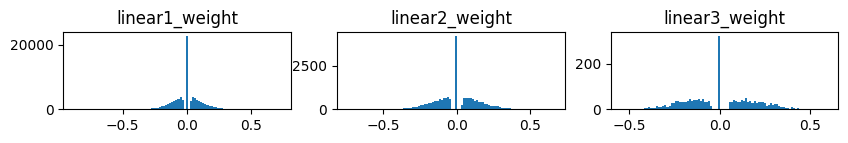

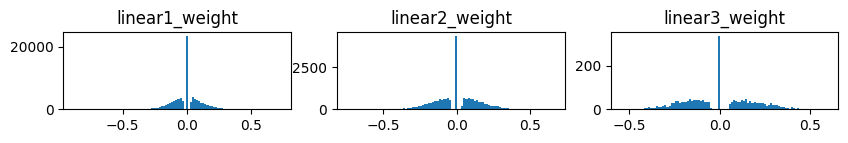

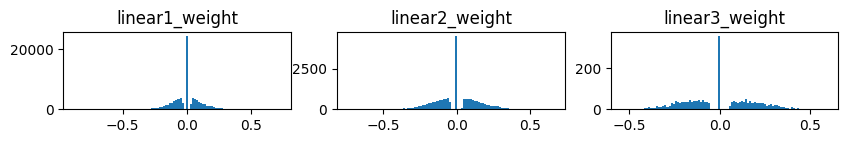

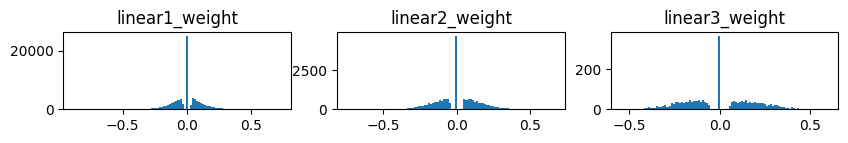

Accuracy of the network on the 10000 test images: 97.47 %


In [5]:
# load dict
model3 = FCNN()
model3.load_state_dict(torch.load('../saveddict/FCNN_MNIST.pt'))

# process with the k-th layer's weights
# thres_nr_zo = std(W_k) * (alpha + beta*i)
# if |W_k| < thres_nr_zo, then W_k = 0

linear1_weight = model3.linear1.weight.data
linear2_weight = model3.linear2.weight.data
linear3_weight = model3.linear3.weight.data
# perform thres to linear1_weight and linear1_bias
linear1_weight = linear1_weight.cpu().numpy().reshape(100, 784).flatten()
linear2_weight = linear2_weight.cpu().numpy().reshape(200, 100).flatten()
linear3_weight = linear3_weight.cpu().numpy().reshape(10, 200).flatten()

for i in range(10):
    # calculate std
    std_linear1_weight = np.std(linear1_weight)
    std_linear2_weight = np.std(linear2_weight)
    std_linear3_weight = np.std(linear3_weight)
    # calculate thres
    thres_l1_w = std_linear1_weight * (0.2 + 0.01 * i)
    thres_l2_w = std_linear2_weight * (0.2 + 0.01 * i)
    thres_l3_w = std_linear3_weight * (0.2 + 0.01 * i)
    # perform thres
    linear1_weight[abs(linear1_weight) < thres_l1_w] = 0
    linear2_weight[abs(linear2_weight) < thres_l2_w] = 0
    linear3_weight[abs(linear3_weight) < thres_l3_w] = 0
    # plot hist of linear1_weight123 each iter, in subplots, 1 row 3 cols
    plt.figure(figsize=(10, 1))
    plt.subplot(1, 3, 1)
    plt.hist(linear1_weight, bins=100)
    plt.title('linear1_weight')
    plt.subplot(1, 3, 2)
    plt.hist(linear2_weight, bins=100)
    plt.title('linear2_weight')
    plt.subplot(1, 3, 3)
    plt.hist(linear3_weight, bins=100)
    plt.title('linear3_weight')
    plt.show()


# write the thresed weights to a new model
device = torch.device('cpu')

model4 = FCNN()
model4.load_state_dict(torch.load('../saveddict/FCNN_MNIST.pt'))

# write the linear1_weight, linear2_weight, linear3_weight to the model
model4.linear1.weight.data = torch.from_numpy(linear1_weight.reshape(100, 784)).float().to(device)
model4.linear2.weight.data = torch.from_numpy(linear2_weight.reshape(200, 100)).float().to(device)
model4.linear3.weight.data = torch.from_numpy(linear3_weight.reshape(10, 200)).float().to(device)

# test the model
test_dataset = dsets.MNIST(root='../data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=200, shuffle=False)

# test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 784).to(device)
        labels = labels.to(device)
        outputs = model4(images, [1,1,1])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Accuracy of removed weight: {} %'.format(100 * correct / total))

# save the model
torch.save(model4.state_dict(), '../saveddict/FCNN_MNIST_rmvd.pt')

In [6]:
model5 = FCNN()
model5.load_state_dict(torch.load('../saveddict/FCNN_MNIST_rmvd.pt'))
# print min and max value for each weight
print(torch.min(model5.linear1.weight.data), torch.max(model5.linear1.weight.data))
print(torch.min(model5.linear2.weight.data), torch.max(model5.linear2.weight.data))
print(torch.min(model5.linear3.weight.data), torch.max(model5.linear3.weight.data))

tensor(-0.8809) tensor(0.7344)
tensor(-0.7463) tensor(0.6682)
tensor(-0.5476) tensor(0.6000)


# SC-inference

### SC-tools(new)

In [27]:
def SNG_10_matrix(seed_matrix: np.array, target_matrix: np.array,
                  bitstream_length=1024, bit1=7, bit2=10, isprint=False):

    lfsr_matrix = seed_matrix.copy()
    target_matrix = (target_matrix + 1) / 2 * 1023

    output_stream_matrix = np.zeros((seed_matrix.shape[0], seed_matrix.shape[1], bitstream_length), dtype=np.int8)

    # Create weights matrix to convert binary matrix to integers
    weights = np.array([2**i for i in reversed(range(seed_matrix.shape[2]))])
    # if isprint: print('weights: \n',weights) # [512 256 128  64  32  16   8   4   2   1]

    for i in range(bitstream_length):
        xorbits = lfsr_matrix[:,:, 10-bit1] ^ lfsr_matrix[:,:, 10-bit2]
        lfsr_matrix = np.roll(lfsr_matrix, -1, axis=2)
        lfsr_matrix[:,:, 9] = xorbits

        # Matrix multiplication to get integer values
        lfsr_values = (lfsr_matrix * weights).sum(axis=2)
        
        # Set output_stream_matrix values based on the condition
        output_stream_matrix[:,:, i] = (lfsr_values <= target_matrix).astype(np.int8)

    return output_stream_matrix


def Tanh_for_apc(stm:np.array, operands:int):

    logg = False
    output_stream = np.zeros(stm.shape[0], dtype=int)
    # create state num by opends
    scale = 1
    qq = 1.835*(2*operands) ** (-0.5552)
    r_ = (2*(1-scale)*(operands-1)) / scale*(1-qq) + 2*(operands)
    # r = nearest multiple of two(r_), 最近的2的倍数
    r = 2 * round(r_/2)
    state_num = r - 1
    state_half = r / 2
    if logg: print('r:{}, r_:{}, qq:{}'.format(r, r_, qq))
    if logg: print('opends', operands,' state num: ', state_num, 'state half: ', state_half)

    # init state
    state = 0
    # read stm
    for i in range(stm.shape[0]):
        V = stm[i] * 2 - operands
        if logg: print('V: ', V)
        state = state + V
        if logg: print('updtd state: ', state)
        if state > state_num:
            state = state_num
        if state < 0:
            state = 0
        
        # output stream
        if state > state_half:
            output_stream[i] = 1
        elif (state <= state_half):
            output_stream[i] = 0
        else: print('output stream error')

    return output_stream


def SC_matmul(x_mat, w_mat):
    # example: x_mat(1, 784, 2**10), w_mat(10, 784, 2**10), result(1, 10, 2**10)
    result = np.zeros((x_mat.shape[0], w_mat.shape[0], 2**10))
    for i in range(x_mat.shape[0]):
        for j in range(w_mat.shape[0]):
            mul_tmp = np.where(x_mat[i,:,:]==w_mat[j,:,:], 1, 0) #  e.g. save 784 results, for APC add (784,2**10)
            mul_tmp_apc = np.sum(mul_tmp, axis=0) # (2**10)
            result[i,j,:] = Tanh_for_apc(mul_tmp_apc, x_mat.shape[1])

    return result

#### test ####
xx = np.random.uniform(0,1,(1,784))
xx_sed = np.random.randint(0, 2, (1, 784, 10)) # seed
# remove value in xx which near 0
xx[np.abs(xx)<0.1] = 0
ww = np.random.uniform(-1,1,(10,784))
ww[np.abs(ww)<0.1] = 0
ww_sed = np.random.randint(0, 2, (10, 784, 10)) # seed

sc_xx = SNG_10_matrix(xx_sed, xx)
sc_ww = SNG_10_matrix(ww_sed, ww)
print('sc_xx shape: ', sc_xx.shape)
print('sc_ww shape: ', sc_ww.shape)

sc_result = SC_matmul(sc_xx, sc_ww)
print('sc_result shape: ', sc_result.shape)

# check value
baseline = np.matmul(xx, ww.T) # (1, 10)
print('baseline: ', np.tanh(baseline))
print('sc_result: ', np.mean(sc_result, axis=2)*2-1) # (1, 10, 1024)


sc_xx shape:  (1, 16, 1024)
sc_ww shape:  (10, 16, 1024)
sc_result shape:  (1, 10, 1024)
baseline:  [[-0.9987215  -0.92537702  0.84604953 -0.0308975  -0.91666283  0.98977533
  -0.96221531  0.38320802  0.94330995 -0.8939799 ]]
sc_result:  [[-1.         -0.93554688  0.75390625 -0.1640625  -0.89257812  0.96484375
  -0.9609375   0.31445312  0.8984375  -0.90820312]]
error: 0.04149013076339721


### old and slow

In [11]:
# SC tools
# SNG
def SNG_10(seed: int, target: float,
        bitstream_length=1024, bit1=7, bit2=10, isprint=False):

    # check the seed in range (0-1023)
    assert seed > 0 and seed < 1023, "seed should be in range (0-1023)"
    # check the target in range (-1, 1)
    assert target >= -1 and target <= 1, "target should be in range (-1, 1)"
    
    # convert seed to binary
    seed_bin_str = format(seed, '010b')
    seed = np.array([int(i) for i in seed_bin_str])

    # convert target to unipolar
    target = (target + 1) / 2 # (-1, 1) -> (0, 1)
    target_10 = target * 1023

    lfsr = seed.copy()
    output_stream = np.zeros(bitstream_length)

    # do xor on bit1 and bit2
    for i in range(bitstream_length):
        xorbit = lfsr[10-bit1] ^ lfsr[10-bit2]  # xor on bit7 and bit10
        lfsr = np.roll(lfsr, -1)                # shift left
        lfsr[9] = xorbit                        # set xorbit to bit0
        lfsr_val = int(''.join([str(i) for i in lfsr]), 2) # array->binary->int
        if isprint: print(lfsr_val)
        if lfsr_val <= target_10:
            output_stream[i] = 1
        else:
            output_stream[i] = 0

    return output_stream

# generate matrix using SNG
def gen_mat(mat:np.array):
    # for each element in mat, generate a 1024 bitstream
    mat_out = np.zeros((mat.shape[0], mat.shape[1], 2**10))
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            seed = np.random.randint(1, 2**10-1)
            mat_out[i][j] = SNG_10(seed, mat[i][j])

    return mat_out


def ADD_apc(neuron_tmp: np.array):
    # example: neuron_tmp(784, 2**10)
    # count the number of 1 in each column, the count result is the output of APC
    output_stm = np.zeros((2**10))
    for i in range(neuron_tmp.shape[1]):
        output_stm[i] = np.sum(neuron_tmp[:, i])
    return output_stm


def MUL_bip(x1: np.array, x2: np.array):
    assert x1.shape == x2.shape, 'shape not match, multiplying failed'
    return np.where(x1==x2, 1, 0)


def Tanh_for_apc(stm:np.array, opends):

    logg = False
    output_stream = np.zeros(stm.shape[0], dtype=int)
    # create state num by opends
    scale = 1
    qq = 1.835*(2*opends) ** (-0.5552)
    r_ = (2*(1-scale)*(opends-1)) / scale*(1-qq) + 2*(opends)
    # r = nearest multiple of two(r_), 最近的2的倍数
    r = 2 * round(r_/2)
    state_num = r - 1
    state_half = r / 2
    if logg: print('r:{}, r_:{}, qq:{}'.format(r, r_, qq))
    if logg: print('opends', opends,' state num: ', state_num, 'state half: ', state_half)

    # init state
    state = 0
    # read stm
    for i in range(stm.shape[0]):
        V = stm[i] * 2 - opends
        if logg: print('V: ', V)
        state = state + V
        if logg: print('updtd state: ', state)
        if state > state_num:
            state = state_num
        if state < 0:
            state = 0
        
        # output stream
        if state > state_half:
            output_stream[i] = 1
        elif (state <= state_half):
            output_stream[i] = 0
        else: print('output stream error')

    return output_stream
    

def SC_mat_mul(x_mat, w_mat, x_real=0, w_real=0): 
    # example shape: x_mat (1,784), w_mat (100,784), x_real (1,784), w_real (784,100)
    result = np.zeros((x_mat.shape[0], w_mat.shape[0], 2**10))
    assert x_mat.shape[1] == w_mat.shape[1], 'shape not match, multiplying failed'
    for i in range(x_mat.shape[0]):
        for j in range(w_mat.shape[0]):
            # print('output col: {}'.format(j))
            mul_tmp = np.zeros((x_mat.shape[1], 2**10)) # e.g. save 784 results, for APC add
            for k in range(x_mat.shape[1]):
                if (x_real[i, k]==0) or (w_real[j, k]==0):
                    seed = np.random.randint(1, 2**10-1)
                    mul = SNG_10(seed, 0) # no mul
                else:
                    mul = MUL_bip(x_mat[i, k], w_mat[j, k])
                mul_tmp[k] = mul
            # APC add
            mul_tmp_res = ADD_apc(mul_tmp)
            # print('mul_tmp_res: {}'.format(mul_tmp_res)) # [400, 328, ...], shape(2**10,)
            # tanh
            tanh_res = Tanh_for_apc(mul_tmp_res, x_mat.shape[1])
            # print('tanh_res: {}'.format(tanh_res))
            result[i, j] = tanh_res
            print('output col: {}, value {}'.format(j, tanh_res.mean()*2-1))
    
    return result


### make SC weight and x

In [32]:
# read the model
model6 = FCNN()
model6.load_state_dict(torch.load('../saveddict/FCNN_MNIST_rmvd.pt'))

# extract the weights
linear1_weight = model6.linear1.weight.data.cpu().numpy()
linear2_weight = model6.linear2.weight.data.cpu().numpy()
linear3_weight = model6.linear3.weight.data.cpu().numpy()
print(linear1_weight.shape, linear2_weight.shape, linear3_weight.shape)

# generate the matrix
SC_l1_seed = np.random.randint(0, 2, (linear1_weight.shape[0], linear1_weight.shape[1], 10))
SC_l2_seed = np.random.randint(0, 2, (linear2_weight.shape[0], linear2_weight.shape[1], 10))
SC_l3_seed = np.random.randint(0, 2, (linear3_weight.shape[0], linear3_weight.shape[1], 10))
SC_linear1_weight = SNG_10_matrix(SC_l1_seed, linear1_weight)
SC_linear2_weight = SNG_10_matrix(SC_l2_seed, linear2_weight)
SC_linear3_weight = SNG_10_matrix(SC_l3_seed, linear3_weight)

# save the matrix
np.save('../data/SC_lin1_w.npy', SC_linear1_weight)
np.save('../data/SC_lin2_w.npy', SC_linear2_weight)
np.save('../data/SC_lin3_w.npy', SC_linear3_weight)
# use 4 sec.

(100, 784) (200, 100) (10, 200)


In [33]:
for i in range(5):
    print(linear3_weight[5][i])
    print((SC_linear3_weight[5][i]).mean()*2 -1)
    print('---------------------------------')

0.26260465
0.259765625
---------------------------------
-0.16202635
-0.1640625
---------------------------------
0.108349115
0.10546875
---------------------------------
0.31688944
0.31640625
---------------------------------
0.49171233
0.4921875
---------------------------------


In [35]:
test_dataset = dsets.MNIST(root='../data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

SC_img_seed = np.random.randint(0, 2, (1, 784, 10))
test_dataset_SC = np.zeros((1000, 1, 784, 1024), dtype=np.float32)
for i, (image, _) in enumerate(test_loader):
    if i<1000:
        image = image.view(1, 784).numpy()
        image_SC = SNG_10_matrix(SC_img_seed, image)
        # print(image_SC.shape) # (1, 784, 1024)
        test_dataset_SC[i] = image_SC
        print(i,' completed')
    else:
        break

# save the SC test dataset
np.save('../data/saved sc weight/test_dataset_SC.npy', test_dataset_SC) # (100, 1, 784, 1024)

0  completed
1  completed
2  completed
3  completed
4  completed
5  completed
6  completed
7  completed
8  completed
9  completed
10  completed
11  completed
12  completed
13  completed
14  completed
15  completed
16  completed
17  completed
18  completed
19  completed
20  completed
21  completed
22  completed
23  completed
24  completed
25  completed
26  completed
27  completed
28  completed
29  completed
30  completed
31  completed
32  completed
33  completed
34  completed
35  completed
36  completed
37  completed
38  completed
39  completed
40  completed
41  completed
42  completed
43  completed
44  completed
45  completed
46  completed
47  completed
48  completed
49  completed
50  completed
51  completed
52  completed
53  completed
54  completed
55  completed
56  completed
57  completed
58  completed
59  completed
60  completed
61  completed
62  completed
63  completed
64  completed
65  completed
66  completed
67  completed
68  completed
69  completed
70  completed
71  completed
72

In [40]:
test_labels = [label for _, label in test_dataset]
print(len(test_labels))

10000


# test x*W

In [41]:
# prepare SC data
test_dataset_SC = np.load('../data/saved sc weight/test_dataset_SC.npy')
SC_linear1_weight = np.load('../data/SC_lin1_w.npy')
SC_linear2_weight = np.load('../data/SC_lin2_w.npy')
SC_linear3_weight = np.load('../data/SC_lin3_w.npy')

print(test_dataset_SC.shape)
#############################################
correct, count = 0, 0
for i in range(test_dataset_SC.shape[0]):
    test_img = test_dataset_SC[i]
    # linear 1
    l1_out = SC_matmul(test_img, SC_linear1_weight)
    # linear 2
    l2_out = SC_matmul(l1_out, SC_linear2_weight)
    # linear 3
    l3_out = SC_matmul(l2_out, SC_linear3_weight)
    # result
    pred = np.argmax(np.mean(l3_out, axis=2)*2-1, axis=1)
    lab = test_labels[i]
    if pred == lab:
        correct += 1
    else: print('wrong prediction: pred{}, label{} '.format(pred, lab))
    count += 1

print('SC accuracy: ', correct/count)
# 9m 17.6s

(1000, 1, 784, 1024)
wrong prediction: pred[2], label5 
wrong prediction: pred[2], label6 
wrong prediction: pred[2], label3 
wrong prediction: pred[2], label6 
wrong prediction: pred[9], label7 
wrong prediction: pred[9], label3 
wrong prediction: pred[9], label5 
wrong prediction: pred[1], label5 
wrong prediction: pred[9], label4 
wrong prediction: pred[2], label6 
wrong prediction: pred[9], label7 
wrong prediction: pred[9], label3 
wrong prediction: pred[9], label7 
wrong prediction: pred[2], label6 
wrong prediction: pred[2], label6 
wrong prediction: pred[1], label9 
wrong prediction: pred[9], label3 
wrong prediction: pred[9], label1 
wrong prediction: pred[2], label6 
wrong prediction: pred[2], label6 
wrong prediction: pred[3], label7 
wrong prediction: pred[9], label4 
wrong prediction: pred[3], label7 
wrong prediction: pred[9], label5 
wrong prediction: pred[9], label4 
wrong prediction: pred[9], label6 
wrong prediction: pred[9], label2 
wrong prediction: pred[2], label6 